<a href="https://colab.research.google.com/github/protogia/Braunschweig/blob/main/Opendata-Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opendata Meta Information Overview

## Prologue
This notebook is a try to analyse the metadata informations of the provided [opendata sources](https://www.braunschweig.de/digitalisierung-online-services/open-data.php) from the city of Braunschweig. It uses an python-based govdata-client to extract some informations from the provided metdata.

## Setup

First we install the [govdata-client](https://pypi.org/project/govdata/) via pip and further dependencies we'll need to import in the next step.

*Furthermore we set some basic configuration for the diagram-layout which will be used later.*

In [ ]:
%%capture
!pip install govdata
!pip install pandas

In [ ]:
# SET DIAGRAM-LAYOUT FOR Jypter-Notebook

from IPython.core.display import display, HTML

# Set notebook width to 100%
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.autolayout'] = True

In [ ]:
import govdata
import pandas as pd

Now we can import and initialize an **DKANPortalClient** for our city of interest. To test if the cityclient can establish a connection we can do a connectiontest:

In [ ]:
cityclient = govdata.DKANPortalClient(city="braunschweig", apiversion=3)

In [ ]:
# cityclient.connectiontest() # optional

## Exposing the publisher-frequency

First we van list available packages for our choosen city. A package represents a topic like *infrastructure*, *traffic*, etc.

In [ ]:
cityclient.get_packages()

['verzeichnungsdaten-sterbefälle-1876',
 'passantenfrequenzen-innenstadt',
 'interessengebiete',
 'stadtkarte-1-5000',
 'stadtplan-1-20000',
 'stadtübersicht-1-40000',
 'radverkehrsnetz',
 'regionalkarte-1-100000',
 'stadtbezirke',
 'wahlbezirke',
 'statistische-bezirke',
 'höhenlinien',
 'rundgang-blik-kraheweg',
 'rundgang-blik-uhdeweg',
 'rundgang-blik-kleine-dörfer-weg',
 'rundgang-braunschweiger-ringgleis',
 'rundgang-natur-erleben-riddagshausen',
 'straßenverzeichnis',
 'demographie',
 'überschwemmungsgebiet-oker',
 'überschwemmungsgebiet-schunter',
 'überschwemmungsgebiet-wabe',
 'wasserschutzgebiet',
 'lärmkartierung-straße-nachtsüber-prognose-2025',
 'fahrstreifengenaue-straßenkarte-des-innenstadtrings',
 'fahrstreifengenaue-straßenkarte-vom-rebenring-zum-flughafen',
 'e-tretroller-geschäftsgebiet',
 'e-tretroller-parkverbotszonen',
 'verkehrsmengenkarte-öpnv-stand-2016',
 'verkehrsmengenkarte-kfz-stand-2016',
 'eigenwirtschaftliche-glasfaserausbaugebiete',
 'ifh-kundenbefragu

To get an total overview we'll fetch the packagenames and the relating metadata using the following api-function. We'll store the data into a `pandas.DataFrame` for easier data processing.

In [ ]:
total = cityclient.get_total_packages_with_resources()

df = pd.DataFrame(total)
df["metadata_created"] = pd.to_datetime(df["metadata_created"])
df['metadata_created'] = df['metadata_created'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x) # add tz-info if not available
df.columns.to_list()

['id',
 'name',
 'title',
 'author',
 'author_email',
 'maintainer',
 'maintainer_email',
 'license_title',
 'license_id',
 'notes',
 'url',
 'state',
 'private',
 'revision_timestamp',
 'metadata_created',
 'metadata_modified',
 'creator_user_id',
 'type',
 'resources',
 'tags',
 'log_message',
 'groups']

We got informations about authors, maintainers, resvision-dates, dataset-types and further. Now, we'll check the publisher-frequency of the opendata-providers in Braunschweig.

To do so, we group the packages into monthly-intervals:

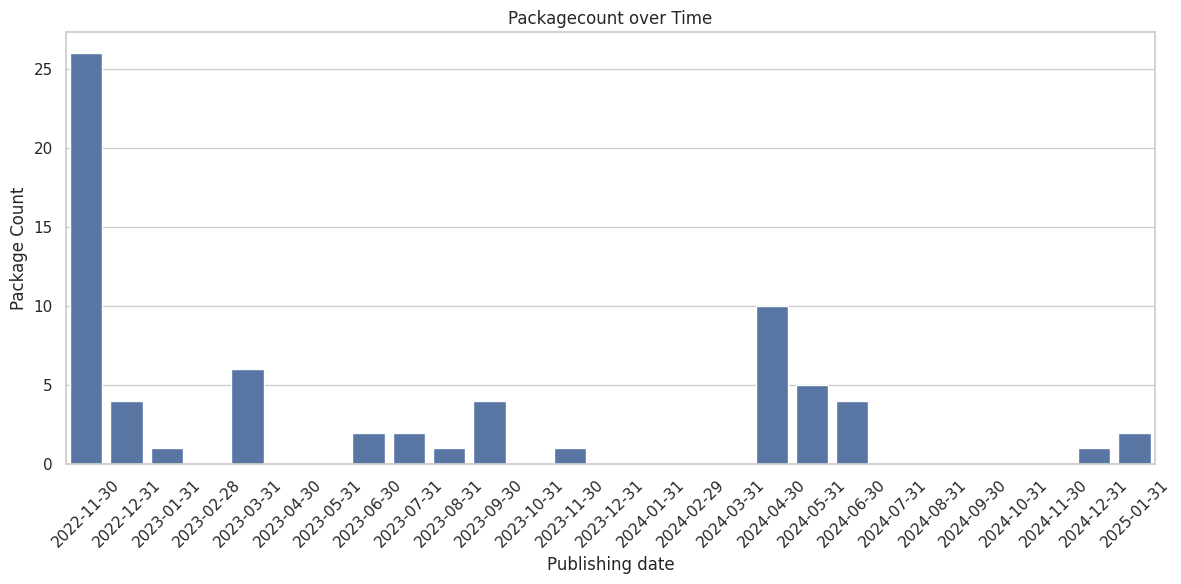

In [ ]:
df.head(n=3)

monthly_grouped = df.groupby(pd.Grouper(key="metadata_created", freq="M")).sum(numeric_only=True)
monthly_grouped.columns = ["packages"]
monthly_grouped = monthly_grouped.sort_values(by="metadata_created", ascending=True)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the bar plot
sns.barplot(x='metadata_created', y='packages', data=monthly_grouped)

# Set labels and title
plt.title('Packagecount over Time')
plt.xlabel('Publishing date')
plt.ylabel('Package Count')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

As we see, it seems when Braunschweig started the project, they launched the most packages. Within 2023 they published the most packages per month.

Now I want to get more information about tag-diversity. We can use the information about tag-diversity to expose informations about periodical consitency of the publishing-frequency per `tag`.  

A `tag` represents the dataset-category. We'll plot the dataset-count per `tag` (category), whereas the category-names are listed on the x-axis.

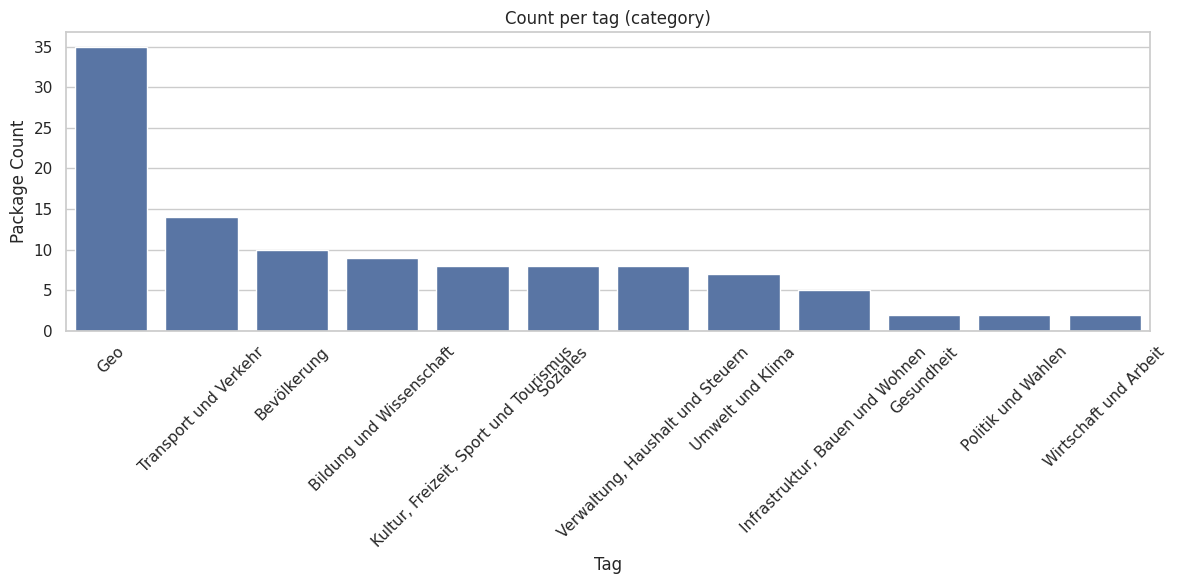

In [ ]:
# create list of tags for x-axis of barplot
taglist = []
for entry in df.tags:
  for tag in entry:
    taglist.append(tag)

# group datasets by tag and count them
taglist = pd.DataFrame(taglist).drop(["id"], axis=1)
tag_grouped = taglist.groupby(by=["name"]).count()
tag_grouped.columns = ["count"]
tag_grouped = tag_grouped.sort_values(by=["count"], ascending=False)

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the bar plot
sns.barplot(x='name', y='count', data=tag_grouped)

# Set labels and title
plt.title('Count per tag (category)')
plt.xlabel('Tag')
plt.ylabel('Package Count')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

Without evaluating the quality of the single datasets we see that there is a quantitative focus on geospatial-, traffic- and population-datasets, whereas datasets about health, politics and economics are less published.

Now we should check how the publisher-frequency per tag changed over time.

In [ ]:
# Exploding the 'tags' list into separate rows
df_exploded = df.explode('tags')
df_exploded['tags'] = df_exploded['tags'].apply(lambda x: x['name'])

# group monthly
df_exploded['month_year'] = df_exploded['metadata_created'].dt.to_period('M')
result = df_exploded.groupby(['tags', 'month_year']).size().reset_index(name='count')
result.sort_values(by=['month_year'], ascending=True, inplace=True)

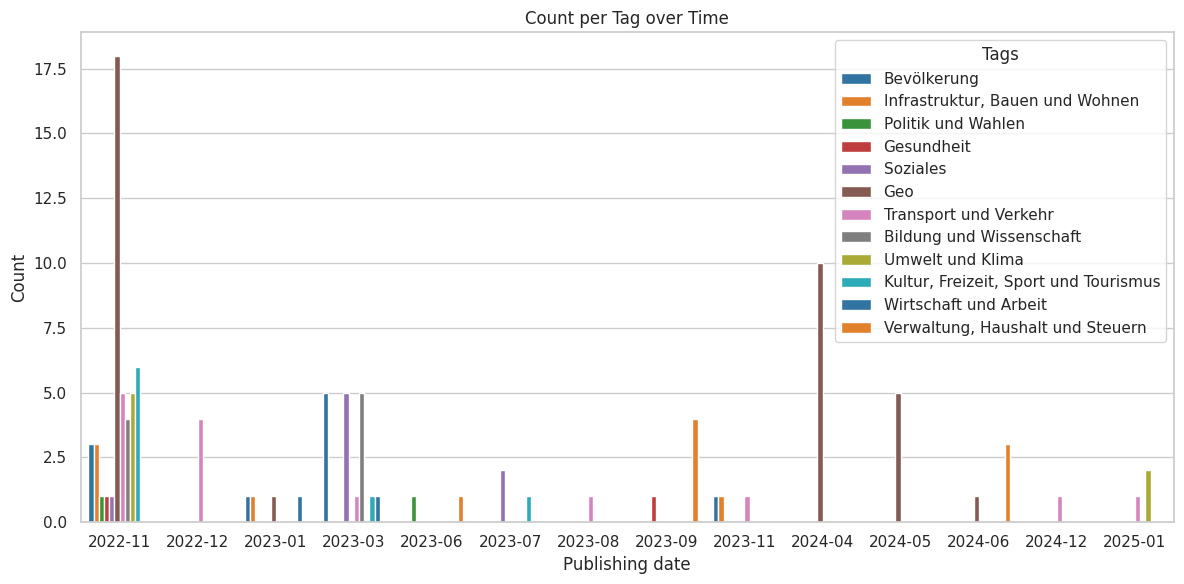

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the bar plot
sns.barplot(x='month_year', y='count', hue='tags', data=result, palette='tab10')

# Set labels and title
plt.title('Count per Tag over Time')
plt.xlabel('Publishing date')
plt.ylabel('Count')
plt.legend(title='Tags', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


As we can see the most periodical publishing is done in the category **Traffic, Government and Taxes, and Geographical Datasets**.

It seems like they have a periodic publishing rate of 2 quaters, whereas datasets in the category of **social** are published yearly.

## Conclusion

This evaluation was just a basic overview of a datasource to get familiar with the opendata-structure.

I plan to checkout certain datasets in detail and also compare the publishing rate Braunschweig with other cities.